In [2]:
!pip install torch torchvision transformers opencv-python scikit-learn datasets seqeval evaluate 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.0 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.2 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha

In [4]:
import random
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
import evaluate
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd
import numpy as np

2025-06-03 20:04:11.589906: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748981051.774033      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748981051.834368      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
import pandas as pd

# Load the CSV file
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTyh006zrmSWoKAwqF92kZ4lvNRKsZL5NYIkdSEK3wtrWA8yMKLT6K3h1k1nyyHjG9ntZvc9tTcbUif/pub?output=csv'
df = pd.read_csv(url,encoding="utf-8")
df.head()

,id,caption,label,level,area,Unnamed: 5
0,1,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
1,2,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
2,3,কুমিল্লা,flood,1.0,কুমিল্লা,NaN
3,4,আখাউড়া উপজেলা ও কসবা উপজেলা'র বিভিন্ন এলাকায় ই...,flood,1.0,আখাউড়া,NaN
4,5,ফেনীর মুহুরী নদীতে পানির মাত্রা গত ৪০ বছরের ইত...,flood,1.0,ফেনী,NaN


In [8]:
# Drop unwanted columns if present
for col in [' id', 'level', 'label', 'Unnamed: 5']:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)

# Remove rows with empty or NaN 'area'
df = df[df['area'].notna() & (df['area'].str.strip() != "")]

# Shuffle dataset
df = shuffle(df, random_state=42).reset_index(drop=True)

In [9]:
# -------- 2. Suffix-based augmentation --------

suffixes = ["এ", "র", "তে", "য়", "য়ে"]

def augment_caption_with_suffixes(caption, areas):
    augmented_caption = caption
    augmented_areas = []
    for area in areas:
        if random.random() < 0.7:
            suffix = random.choice(suffixes)
            augmented_area = area + suffix
            augmented_caption = augmented_caption.replace(area, augmented_area, 1)
            augmented_areas.append(area)  # Keep original label (without suffix)
        else:
            augmented_areas.append(area)
    return augmented_caption, augmented_areas

augmented_data = []
for _, row in df.iterrows():
    caption = row['caption']
    areas = [a.strip() for a in row['area'].split(",")]
    new_caption, new_areas = augment_caption_with_suffixes(caption, areas)
    augmented_data.append({'caption': new_caption, 'area': ",".join(new_areas)})

augmented_df = pd.DataFrame(augmented_data)
df_expanded = pd.concat([df, augmented_df], ignore_index=True)
df_expanded = shuffle(df_expanded, random_state=42).reset_index(drop=True)

In [10]:
# -------- 3. Prepare tokenizer and label mapping --------

model_name = "sagorsarker/bangla-bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

label_list = ["O", "B-LOC", "I-LOC"]
label_to_id = {l: i for i, l in enumerate(label_list)}
id_to_label = {i: l for l, i in label_to_id.items()}

# -------- 4. Tokenization and label alignment --------

def strip_suffix(word):
    for suffix in suffixes:
        if word.endswith(suffix):
            return word[:-len(suffix)]
    return word

def tokenize_and_align_labels(examples):
    captions = examples['caption']
    areas = examples['area']
    tokenized_inputs = tokenizer(
        [caption.split() for caption in captions],
        truncation=True,
        padding='max_length',
        max_length=128,
        is_split_into_words=True,
        return_tensors="pt"
    )
    labels = []
    for i, caption in enumerate(captions):
        words = caption.split()
        word_labels = ['O'] * len(words)
        area_list = [a.strip() for a in areas[i].split(',')] if areas[i] else []
        for idx, word in enumerate(words):
            clean_word = strip_suffix(word)
            for loc in area_list:
                clean_loc = strip_suffix(loc)
                loc_words = clean_loc.split()
                if len(loc_words) == 1 and clean_word == clean_loc:
                    word_labels[idx] = 'B-LOC'
                elif len(loc_words) > 1 and clean_word in [strip_suffix(lw) for lw in loc_words]:
                    loc_idx = [strip_suffix(lw) for lw in loc_words].index(clean_word)
                    if loc_idx == 0:
                        word_labels[idx] = 'B-LOC'
                    else:
                        word_labels[idx] = 'I-LOC'
        token_labels = []
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                token_labels.append(-100)
            elif word_idx != previous_word_idx:
                if word_idx < len(word_labels):
                    token_labels.append(label_to_id[word_labels[word_idx]])
                else:
                    token_labels.append(-100)
            else:
                if word_idx < len(word_labels) and word_labels[word_idx] == 'B-LOC':
                    token_labels.append(label_to_id['I-LOC'])
                else:
                    token_labels.append(-100)
            previous_word_idx = word_idx
        labels.append(token_labels)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

In [11]:
# Prepare tokenized inputs and labels for the entire dataset
# We will do train/test split first
train_df, val_df = train_test_split(df_expanded, test_size=0.1, random_state=42)
train_encodings = tokenize_and_align_labels(train_df.to_dict(orient='list'))
val_encodings = tokenize_and_align_labels(val_df.to_dict(orient='list'))

# Convert labels and inputs to torch dataset
class BanglaNERDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __len__(self):
        return len(self.encodings['input_ids'])
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

train_dataset = BanglaNERDataset(train_encodings)
val_dataset = BanglaNERDataset(val_encodings)

In [12]:
# -------- 5. Define model with CRF --------

import torch.nn as nn
from transformers import AutoModel

class BertForTokenClassificationSimple(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = self.dropout(outputs.last_hidden_state)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(logits.view(-1, logits.shape[-1]), labels.view(-1))

        return (loss, logits) if loss is not None else logits


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForTokenClassificationSimple(model_name, len(label_list)).to(device)

model.safetensors:   0%|          | 0.00/660M [00:00<?, ?B/s]

In [13]:
from torch.utils.data import DataLoader
from seqeval.metrics import precision_score, recall_score, f1_score, accuracy_score
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
epochs = 5
patience = 2  # early stopping patience
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
loss_fct = nn.CrossEntropyLoss(ignore_index=-100)

train_losses = []
val_losses = []
precisions = []
recalls = []
f1s = []
accuracies = []

best_f1 = 0
patience_counter = 0

def align_predictions(predictions, label_ids):
    preds = []
    true_labels = []
    for pred_seq, label_seq in zip(predictions, label_ids):
        pred_labels = []
        true_label_seq = []
        for p, l in zip(pred_seq, label_seq):
            if l != -100:
                pred_labels.append(id_to_label[p.item()])
                true_label_seq.append(id_to_label[l.item()])
        preds.append(pred_labels)
        true_labels.append(true_label_seq)
    return preds, true_labels
    
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids, attention_mask=attention_mask)
        loss = loss_fct(logits.view(-1, logits.shape[-1]), labels.view(-1))

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    all_preds = []
    all_labels = []
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            logits = model(input_ids, attention_mask=attention_mask)
            val_loss = loss_fct(logits.view(-1, logits.shape[-1]), labels.view(-1))
            total_val_loss += val_loss.item()

            preds = torch.argmax(logits, dim=-1)
            preds, trues = align_predictions(preds.cpu(), labels.cpu())
            all_preds.extend(preds)
            all_labels.extend(trues)

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, all_preds)

    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - "
          f"Precision: {precision:.4f} - Recall: {recall:.4f} - F1: {f1:.4f} - Accuracy: {accuracy:.4f}", flush=True)

    # Early stopping
    if f1 > best_f1:
        best_f1 = f1
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}", flush=True)
            break

# Load best model weights
model.load_state_dict(torch.load("best_model.pt"))

/tmp/ipykernel_35/367180617.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 1/5 - Train Loss: 0.1057 - Val Loss: 0.0515 - Precision: 0.6548 - Recall: 0.7371 - F1: 0.6935 - Accuracy: 0.9810
Epoch 2/5 - Train Loss: 0.0344 - Val Loss: 0.0340 - Precision: 0.7939 - Recall: 0.7486 - F1: 0.7706 - Accuracy: 0.9884
Epoch 3/5 - Train Loss: 0.0168 - Val Loss: 0.0242 - Precision: 0.8541 - Recall: 0.9029 - F1: 0.8778 - Accuracy: 0.9923
Epoch 4/5 - Train Loss: 0.0107 - Val Loss: 0.0294 - Precision: 0.8317 - Recall: 0.9600 - F1: 0.8912 - Accuracy: 0.9913
Epoch 5/5 - Train Loss: 0.0081 - Val Loss: 0.0222 - Precision: 0.9240 - Recall: 0.9029 - F1: 0.9133 - Accuracy: 0.9952


<All keys matched successfully>

In [14]:
print(logits.dtype)


torch.float32


In [15]:
# -------- 7. Gazetteer integration (post-processing) --------

# Simple gazetteer of common location names from your dataset areas
gazetteer = set()
for areas in df_expanded['area']:
    for loc in areas.split(","):
        gazetteer.add(loc.strip())

def apply_gazetteer_fix(predicted_tokens, original_caption):
    """
    If any gazetteer location is a substring in the caption,
    add it to predicted locations if not already present.
    """
    preds = set(predicted_tokens)
    for loc in gazetteer:
        if loc in original_caption and loc not in preds:
            preds.add(loc)
    return list(preds)


In [16]:
# -------- 8. Predict function to get locations from text --------

def get_locations_from_predictions(caption, tokenized_input, predictions, tokenizer):
    label_map = {0: "O", 1: "B-LOC", 2: "I-LOC"}
    
    # Convert tensor of input_ids for the first (and only) example in batch to list
    tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"][0].tolist())
    
    word_ids = tokenized_input.word_ids(batch_index=0)  # specify batch index explicitly
    locations = []
    current_loc_tokens = []
    current_word_idx = None

    for idx, pred_label_id in enumerate(predictions):
        label = label_map.get(pred_label_id, "O")
        word_idx = word_ids[idx]
        if word_idx is None:
            continue
        if label == "B-LOC":
            if current_loc_tokens:
                loc_word = tokenizer.convert_tokens_to_string(current_loc_tokens).replace(" ", "")
                locations.append(loc_word)
                current_loc_tokens = []
            current_loc_tokens.append(tokens[idx])
            current_word_idx = word_idx
        elif label == "I-LOC":
            if current_loc_tokens and word_idx == current_word_idx:
                current_loc_tokens.append(tokens[idx])
            elif current_loc_tokens:
                current_loc_tokens.append(" " + tokens[idx])
                current_word_idx = word_idx
        else:
            if current_loc_tokens:
                loc_word = tokenizer.convert_tokens_to_string(current_loc_tokens).replace(" ", "")
                locations.append(loc_word)
                current_loc_tokens = []
                current_word_idx = None

    if current_loc_tokens:
        loc_word = tokenizer.convert_tokens_to_string(current_loc_tokens).replace(" ", "")
        locations.append(loc_word)
    
    # Clean tokens and strip suffixes
    cleaned_locations = []
    for loc in locations:
        cleaned = loc.replace("##", "").replace(" ", "")
        for suffix in suffixes:
            if cleaned.endswith(suffix):
                cleaned = cleaned[:-len(suffix)]
                break
        cleaned_locations.append(cleaned)
    
    # Apply gazetteer fix (if you have it)
    cleaned_locations = apply_gazetteer_fix(cleaned_locations, caption)
    
    return cleaned_locations


def predict_locations(text):
    model.eval()
    with torch.no_grad():
        tokenized = tokenizer(text.split(), truncation=True, padding='max_length', max_length=128, is_split_into_words=True, return_tensors="pt").to(device)
        predictions = model(tokenized['input_ids'], attention_mask=tokenized['attention_mask'])
        locations = get_locations_from_predictions(text, tokenized, predictions[0], tokenizer)
        return locations

In [17]:
import random

# Pick 5 random indices from validation set
val_indices = list(range(len(val_df)))
random.seed(42)
sample_indices = random.sample(val_indices, 5)

print("\n=== Random 5 Unseen Samples and Predictions ===\n")
for idx in sample_indices:
    sample_caption = val_df.iloc[idx]['caption']
    actual_areas = val_df.iloc[idx]['area'].split(",") if val_df.iloc[idx]['area'] else []
    actual_areas = [a.strip() for a in actual_areas]

    predicted_areas = predict_locations(sample_caption)
    
    print(f"Caption     : {sample_caption}")
    print(f"Actual Areas: {actual_areas}")
    print(f"Predicted   : {predicted_areas}")
    print("-" * 40)



=== Random 5 Unseen Samples and Predictions ===

Caption     : ফরিদপুরে নদীভাঙনের তাণ্ডবে তলিয়ে যাচ্ছে বসতবাড়ি, কোথায় যাবে মানুষ?
Actual Areas: ['ফরিদপুর']
Predicted   : ['ফরিদপুর']
----------------------------------------
Caption     : ভূমিকম্পে নিহত এক ব্যক্তির লাশ উদ্ধার। গতকাল সোমবার মরক্কোর আমিজমিজের কাছের একটি গ্রামে
Actual Areas: ['মরক্কো']
Predicted   : ['মরক্কো']
----------------------------------------
Caption     : আয়ারল্যান্ডের আটলান্টিক উপকূলে প্লাস্টিক ও মাইক্রোপ্লাস্টিকের স্তূপ
Actual Areas: ['আয়ারল্যান্ড']
Predicted   : ['উপকূল', 'আয়ারল্যান্ড']
----------------------------------------
Caption     : দুমড়েমুচড়ে যাওয়া একটি বাইসাইকেল। সানলিউফরা, তুরস্ক
Actual Areas: ['তুরস্ক']
Predicted   : ['তুরস্ক']
----------------------------------------
Caption     : ইসরায়েলের প্রতিরক্ষামন্ত্রী বলেছেন যে ইসরায়েল গাজায় পুনরায় যুদ্ধ শুরু করেছে এবং বাকি সকল জিম্মিকে মুক্তি না দেওয়া পর্যন্ত লড়াই চালিয়ে যাওয়ার প্রতিশ্রুতি দিয়েছ 
Actual Areas: ['গাজা']
Predicted   : ['গাজা', 

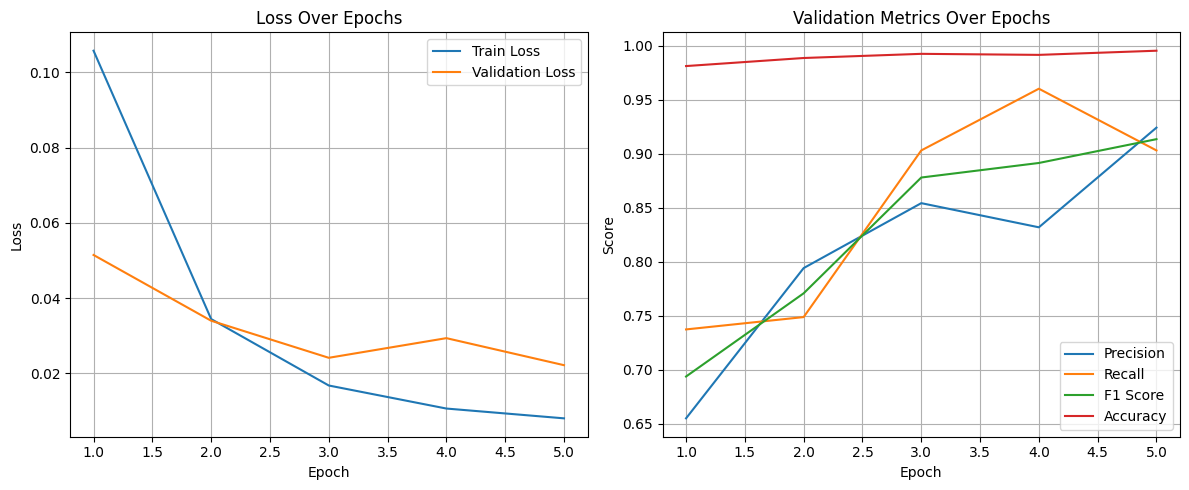

In [18]:
import matplotlib.pyplot as plt
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)

# Metric curves
plt.subplot(1, 2, 2)
plt.plot(epochs_range, precisions, label='Precision')
plt.plot(epochs_range, recalls, label='Recall')
plt.plot(epochs_range, f1s, label='F1 Score')
plt.plot(epochs_range, accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Validation Metrics Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


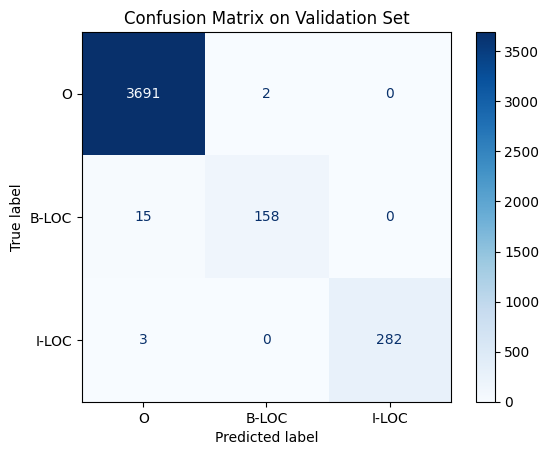

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

flat_preds = [label for seq in all_preds for label in seq]
flat_labels = [label for seq in all_labels for label in seq]

cm = confusion_matrix(flat_labels, flat_preds, labels=label_list)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix on Validation Set')
plt.show()
